In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

In [3]:
our_folders = ['Acne and Rosacea Photos', \
              'Herpes HPV and other STDs Photos', \
              'Atopic Dermatitis Photos']

In [4]:
root_dir = '../input/dermnet/train'
test_dir = '../input/dermnet/test'

In [5]:
acne_train_path = os.path.join(root_dir,'Acne and Rosacea Photos')
herpes_train_path = os.path.join(root_dir, 'Herpes HPV and other STDs Photos')
atopic_train_path = os.path.join(root_dir, 'Atopic Dermatitis Photos')

In [6]:
acne_test_path = os.path.join(test_dir,'Acne and Rosacea Photos')
herpes_test_path = os.path.join(test_dir, 'Herpes HPV and other STDs Photos')
atopic_test_path = os.path.join(test_dir, 'Atopic Dermatitis Photos')

acne_test_files = ([files_ for _, _, files_ in os.walk(acne_test_path)])[0]
herpes_test_files = ([files_ for _, _, files_ in os.walk(herpes_test_path)])[0]
atopic_test_files = ([files_ for _, _, files_ in os.walk(atopic_test_path)])[0]

In [7]:
train_dirs = []
for i in our_folders:
    for folder_,_, files_ in os.walk(f'../input/dermnet/train/{i}'):
        train_dirs.append(folder_)

In [8]:
acne_train_files = ([files_ for _, _, files_ in os.walk(acne_train_path)])[0]
herpes_train_files = ([files_ for _, _, files_ in os.walk(herpes_train_path)])[0]
atopic_train_files = ([files_ for _, _, files_ in os.walk(atopic_train_path)])[0]

In [9]:
def plotGridImages(d_name, list_files, train_path,nrows= 1, ncols=5):
    # for folder_name in our_folders:
    fig = plt.figure(1, figsize=(30, 30))
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.05)
    print(f"{d_name}")
    for i, img_id in enumerate(random.sample(list_files,ncols)):
        ax = grid[i]
        image_dir_path = os.path.join(train_path, img_id)
        img = image.load_img(image_dir_path, target_size=(224, 224), color_mode="rgb")
        img_resized = img.resize((224, 224), resample=Image.BICUBIC)

        img = image.img_to_array(img)
        ax.imshow(img / 255.)
        ax.text(10, 200, 'LABEL: %s' % d_name, color='k', backgroundcolor='w',\
        alpha=0.8)
        ax.axis('off')
    # plt.tight_layout()
    plt.show()

acne


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  # Remove the CWD from sys.path while we load stuff.


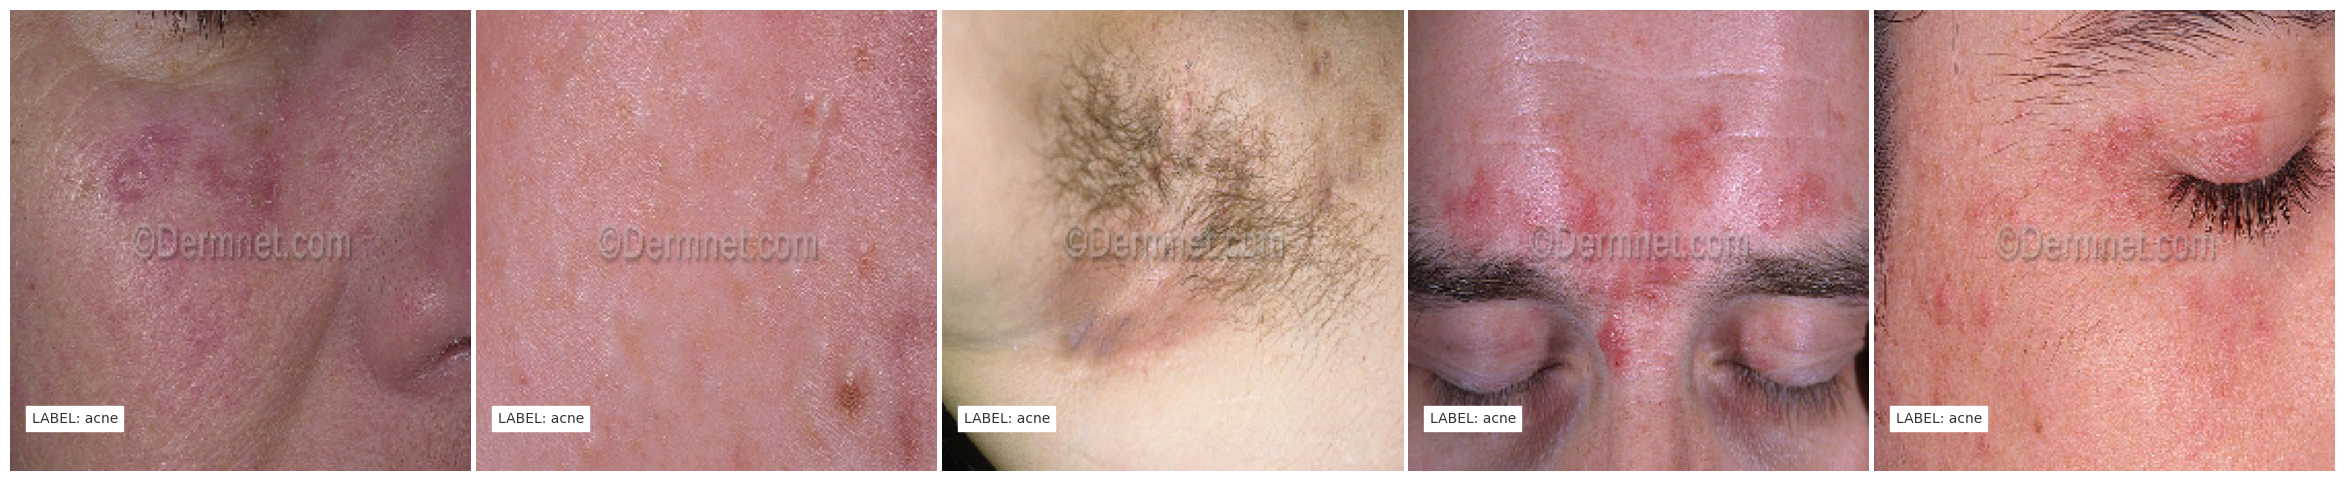

In [10]:
plotGridImages('acne',acne_train_files, acne_train_path,ncols=5)

herpes


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  # Remove the CWD from sys.path while we load stuff.


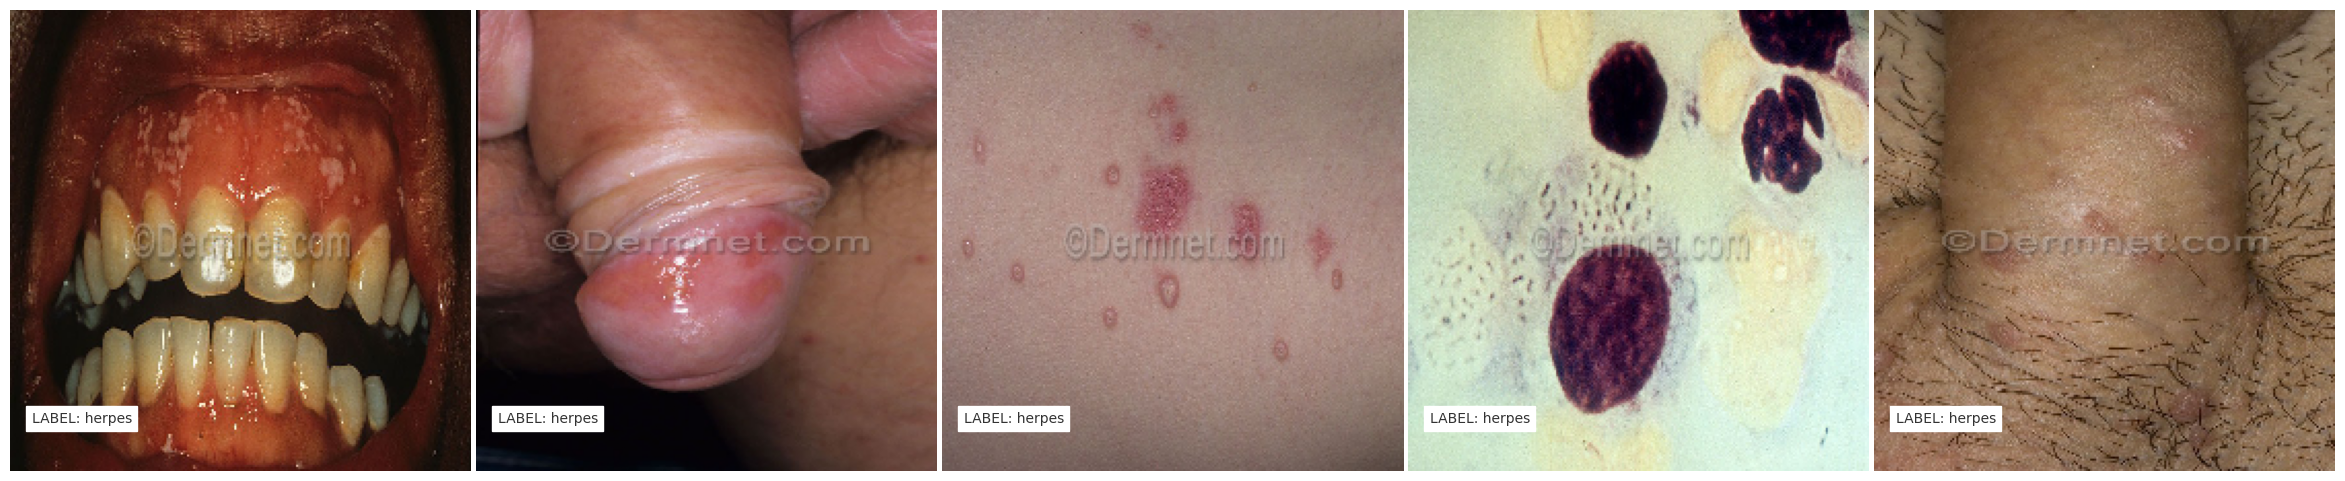

In [11]:
plotGridImages('herpes',herpes_train_files, herpes_train_path,ncols=5)

atopic


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  # Remove the CWD from sys.path while we load stuff.


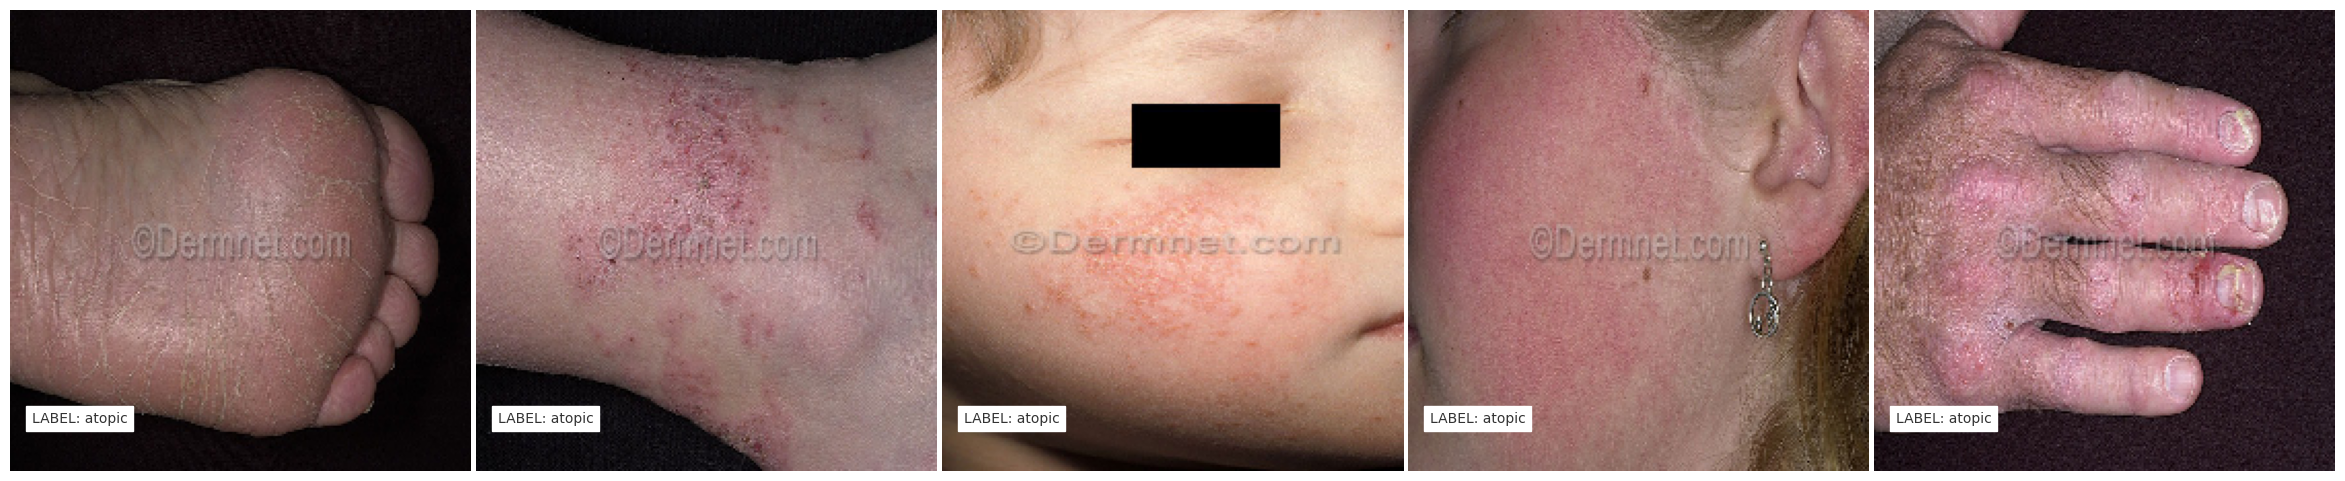

In [12]:
plotGridImages('atopic',atopic_train_files, atopic_train_path,ncols=5)

atopic


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  # Remove the CWD from sys.path while we load stuff.


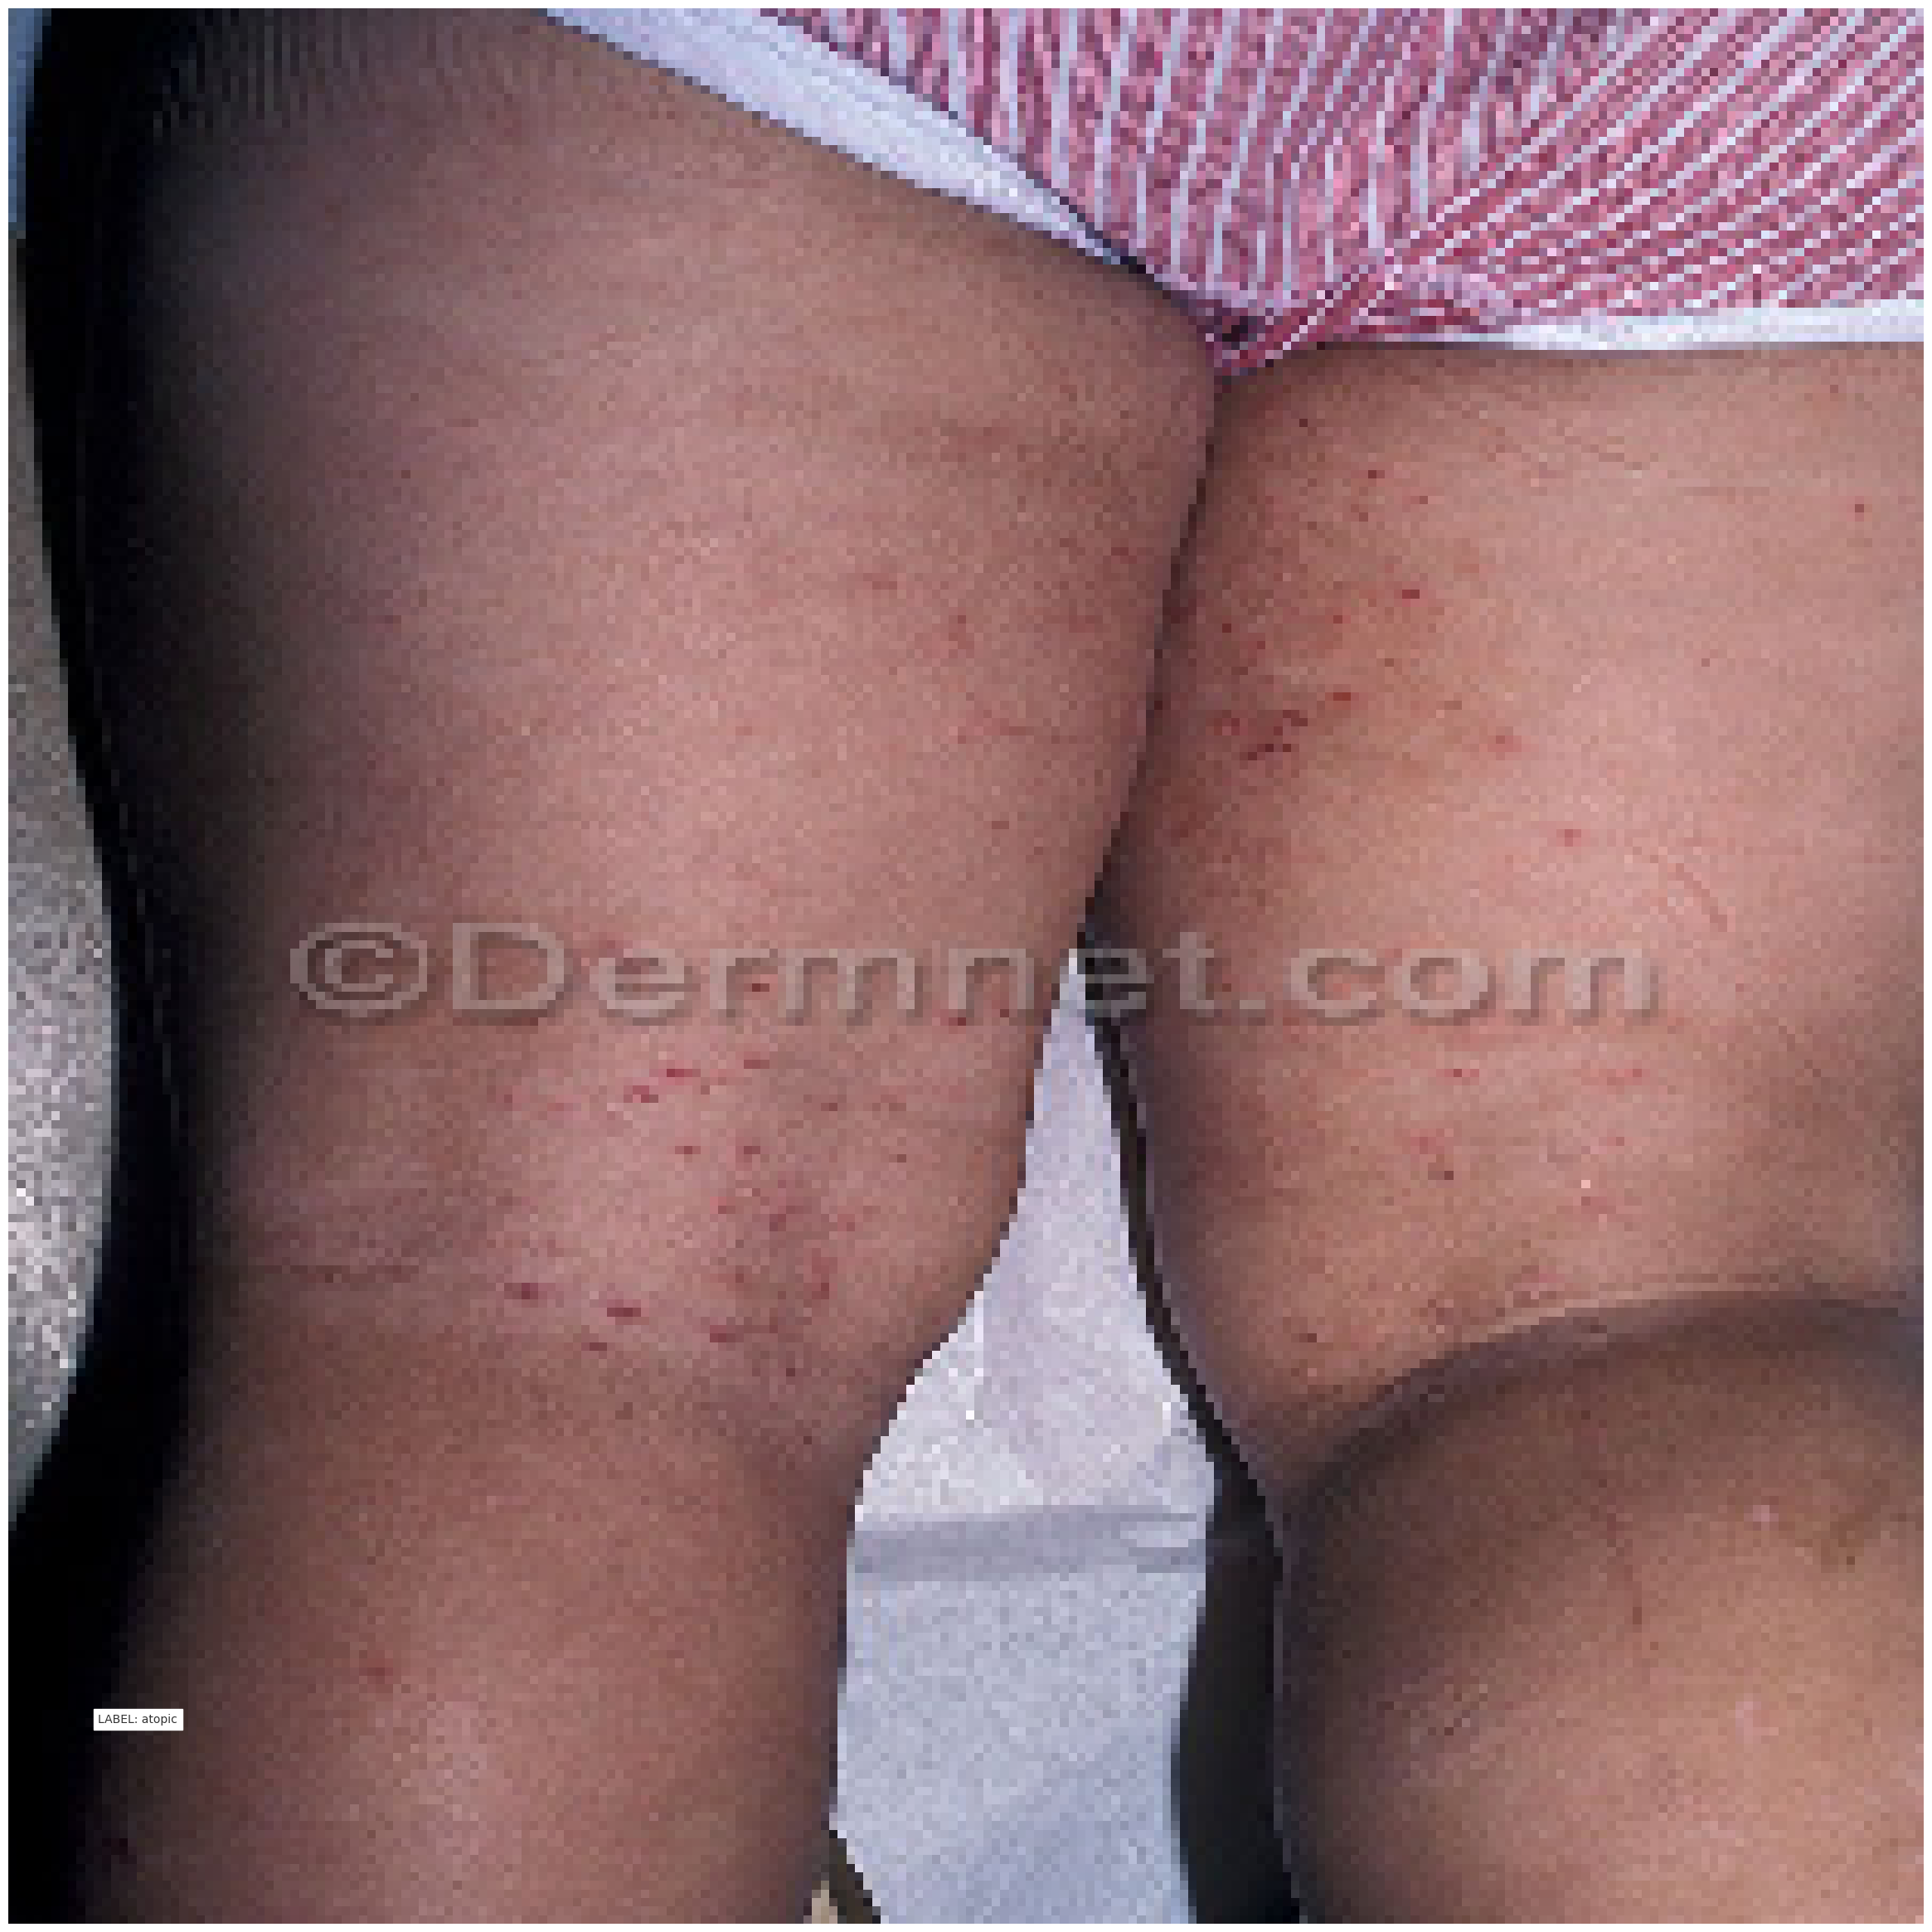

In [13]:
plotGridImages('atopic',atopic_train_files, atopic_train_path,ncols=1)

In [14]:
final_df = pd.DataFrame()

In [15]:
acne_df = pd.DataFrame()
acne_df['Image'] = [acne_train_path+'/'+img for img in acne_train_files]
acne_df['Label'] = "acne"

In [16]:
acne_df.shape

(840, 2)

In [17]:
herpes_df = pd.DataFrame()
herpes_df['Image'] =  [herpes_train_path+'/'+img for img in herpes_train_files]
herpes_df['Label'] = "herpes"

In [18]:
herpes_df.shape

(405, 2)

In [19]:
atopic_df = pd.DataFrame()
atopic_df['Image'] =  [atopic_train_path+'/'+img for img in atopic_train_files]
atopic_df['Label'] = "atopic"

In [20]:
atopic_df.shape

(489, 2)

In [21]:
final_df = final_df.append([acne_df, herpes_df, atopic_df])

In [22]:
final_df.shape

(1734, 2)

In [23]:
final_df.sample(10)

Image   Label
87   ../input/dermnet/train/Atopic Dermatitis Photo...  atopic
94   ../input/dermnet/train/Acne and Rosacea Photos...    acne
351  ../input/dermnet/train/Herpes HPV and other ST...  herpes
313  ../input/dermnet/train/Atopic Dermatitis Photo...  atopic
480  ../input/dermnet/train/Atopic Dermatitis Photo...  atopic
707  ../input/dermnet/train/Acne and Rosacea Photos...    acne
342  ../input/dermnet/train/Acne and Rosacea Photos...    acne
502  ../input/dermnet/train/Acne and Rosacea Photos...    acne
314  ../input/dermnet/train/Acne and Rosacea Photos...    acne
553  ../input/dermnet/train/Acne and Rosacea Photos...    acne

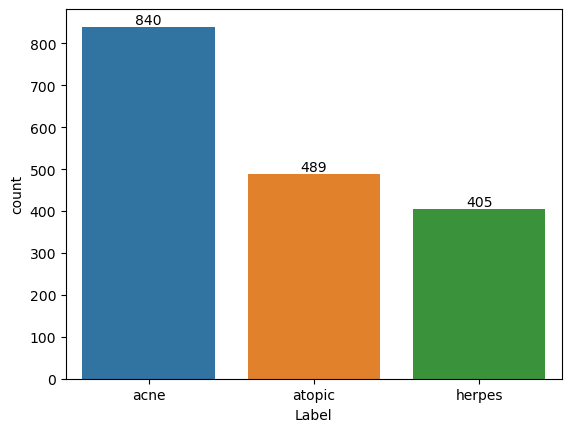

In [24]:
ax = sns.countplot(x=final_df['Label'],
                   order=final_df['Label'].value_counts(ascending=False).index);

abs_values = final_df['Label'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values);

In [25]:
# Observation: Imabalnced dataset

In [26]:
final_test_df = pd.DataFrame()
################# acne #########

acne_test_df = pd.DataFrame()
acne_test_df['Image'] = [acne_test_path+'/'+img for img in acne_test_files]
acne_test_df['Label'] = "acne"

##################  herpes  ##########

herpes_test_df = pd.DataFrame()
herpes_test_df['Image'] =  [herpes_test_path+'/'+img for img in herpes_test_files]
herpes_test_df['Label'] = "herpes"

################  atopic  ##########

atopic_test_df = pd.DataFrame()
atopic_test_df['Image'] =  [atopic_test_path+'/'+img for img in atopic_test_files]
atopic_test_df['Label'] = "atopic"
###########################################
###########################################

final_test_df = final_test_df.append([acne_test_df, 
                                      herpes_test_df, 
                                      atopic_test_df])

final_test_df.shape

(537, 2)

In [27]:
# applying image augmentation techniques

In [28]:
#train_data_gen  = ImageDataGenerator(rescale=1 / 255.0,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip = Truevertical_flip = True,validation_split=0.2,fill_mode='nearest')
#test_data_gen = ImageDataGenerator(rescale=1 / 255.0)
train_data_gen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

test_data_gen = ImageDataGenerator(rescale=1 / 255.0)

In [29]:
batch_size = 128
train_generator = train_data_gen.flow_from_dataframe(
  dataframe=final_df,
   x_col="Image",
    y_col="Label",
   target_size=(256, 256),
   batch_size=batch_size,
   class_mode="categorical",#sparse
    subset='training',
   shuffle=True,
    seed=42
)
valid_generator = train_data_gen.flow_from_dataframe(
   dataframe=final_df,
   x_col="Image",
   y_col="Label",
   target_size=(256, 256),
   batch_size=batch_size,
   class_mode="categorical", #sparse
   subset='validation',
   shuffle=True,
   seed=42 
)
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=final_test_df,
    x_col="Image",
    y_col="Label",
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,)


Found 1388 validated image filenames belonging to 3 classes.
Found 346 validated image filenames belonging to 3 classes.
Found 537 validated image filenames belonging to 3 classes.


In [40]:
# VGG16 with Input shape of our Images
# Include Top is set to false to allow us to add more layers

res = ResNet50(weights ='imagenet', include_top = False, 
               input_shape = (224, 224, 3)) 
               
# Setting the trainable to false
res.trainable = False


x= res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(3, activation ='softmax')(x)
model = Model(res.input, x)


model.compile(optimizer =tf.keras.optimizers.RMSprop(learning_rate=0.0001),  #'Adam'
              loss ="categorical_crossentropy",  #sparse_categorical_crossentropy
             metrics =["categorical_accuracy"])  #sparse_categorical_accuracy

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

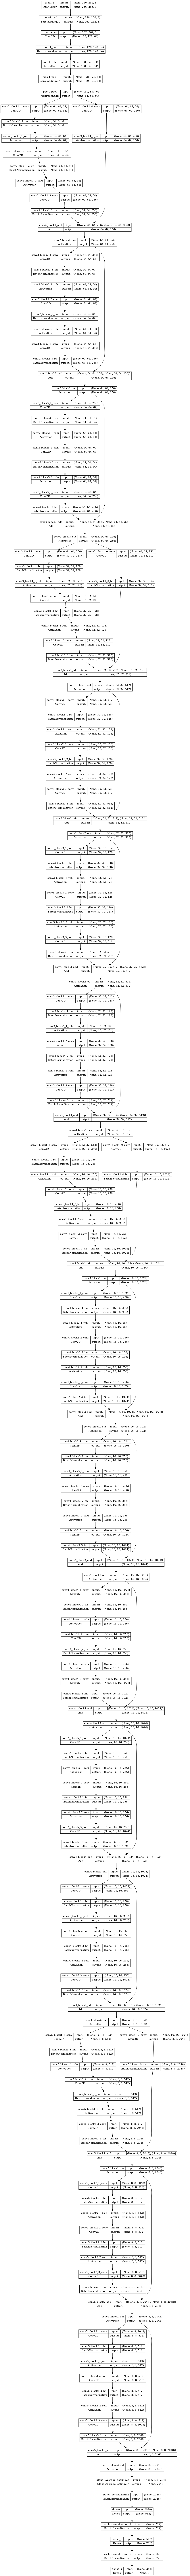

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [43]:
custom_early_stopping = EarlyStopping(
    monitor='categorical_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='max',
    restore_best_weights=True
)

In [44]:
history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data=valid_generator)

Epoch 1/100
11/11 [==============================] - 37s 3s/step - loss: 0.9425 - categorical_accuracy: 0.5735 - val_loss: 1.7792 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 37s 3s/step - loss: 0.9291 - categorical_accuracy: 0.5865 - val_loss: 1.6640 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 38s 3s/step - loss: 0.9385 - categorical_accuracy: 0.5872 - val_loss: 1.6361 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 38s 4s/step - loss: 0.9046 - categorical_accuracy: 0.5944 - val_loss: 1.5394 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 36s 3s/step - loss: 0.8782 - categorical_accuracy: 0.6146 - val_loss: 1.4956 - val_categorical_accuracy: 0.0029
Epoch 6/100
11/11 [==============================] - 37s 3s/step - loss: 0.9011 - categorical_accuracy: 0.5987 - val_loss: 1.4560 - val_categorical_accuracy: 0

Accuracy plot

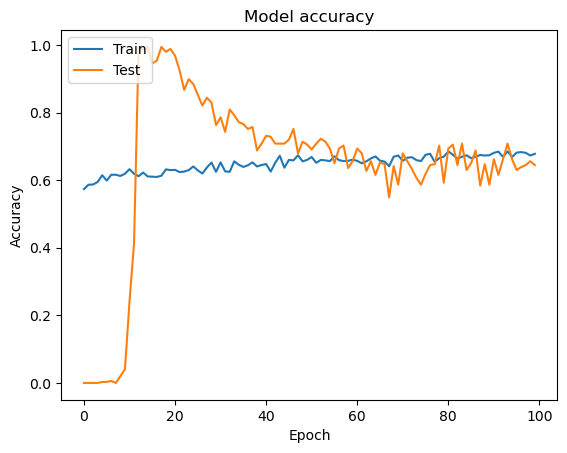

In [45]:
#plot accuracy vs epoch
plt.plot(history.history['categorical_accuracy']) #sparse_categorical_accuracy
plt.plot(history.history['val_categorical_accuracy']) #val_sparse_categorical_accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Loss plot

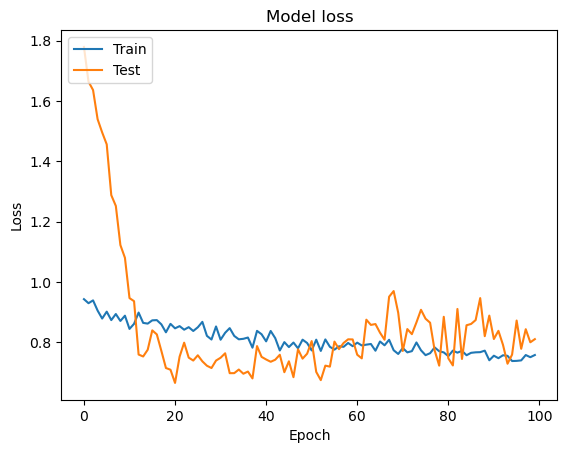

In [47]:
# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
acne_test_df = pd.DataFrame({'label': [0, 1, 1, 0]})
herpes_test_df = pd.DataFrame({'label': [1, 0, 0, 1]})
atopic_test_df = pd.DataFrame({'label': [1, 1, 0, 0]})

# Check whether they are scalar or boolean values
print(np.isscalar(acne_test_df))
print(isinstance(acne_test_df, bool))

print(np.isscalar(herpes_test_df))
print(isinstance(herpes_test_df, bool))

print(np.isscalar(atopic_test_df))
print(isinstance(atopic_test_df, bool))

False
False
False
False
False
False


In [52]:
acne_test_df = pd.DataFrame([True])
herpes_test_df = pd.DataFrame([False])
atopic_test_df = pd.DataFrame([True])

In [57]:
acne_test_df = pd.DataFrame(acne_test_df)
herpes_test_df = pd.DataFrame(herpes_test_df)
atopic_test_df = pd.DataFrame(atopic_test_df)

In [61]:
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(test_true,test_pred)


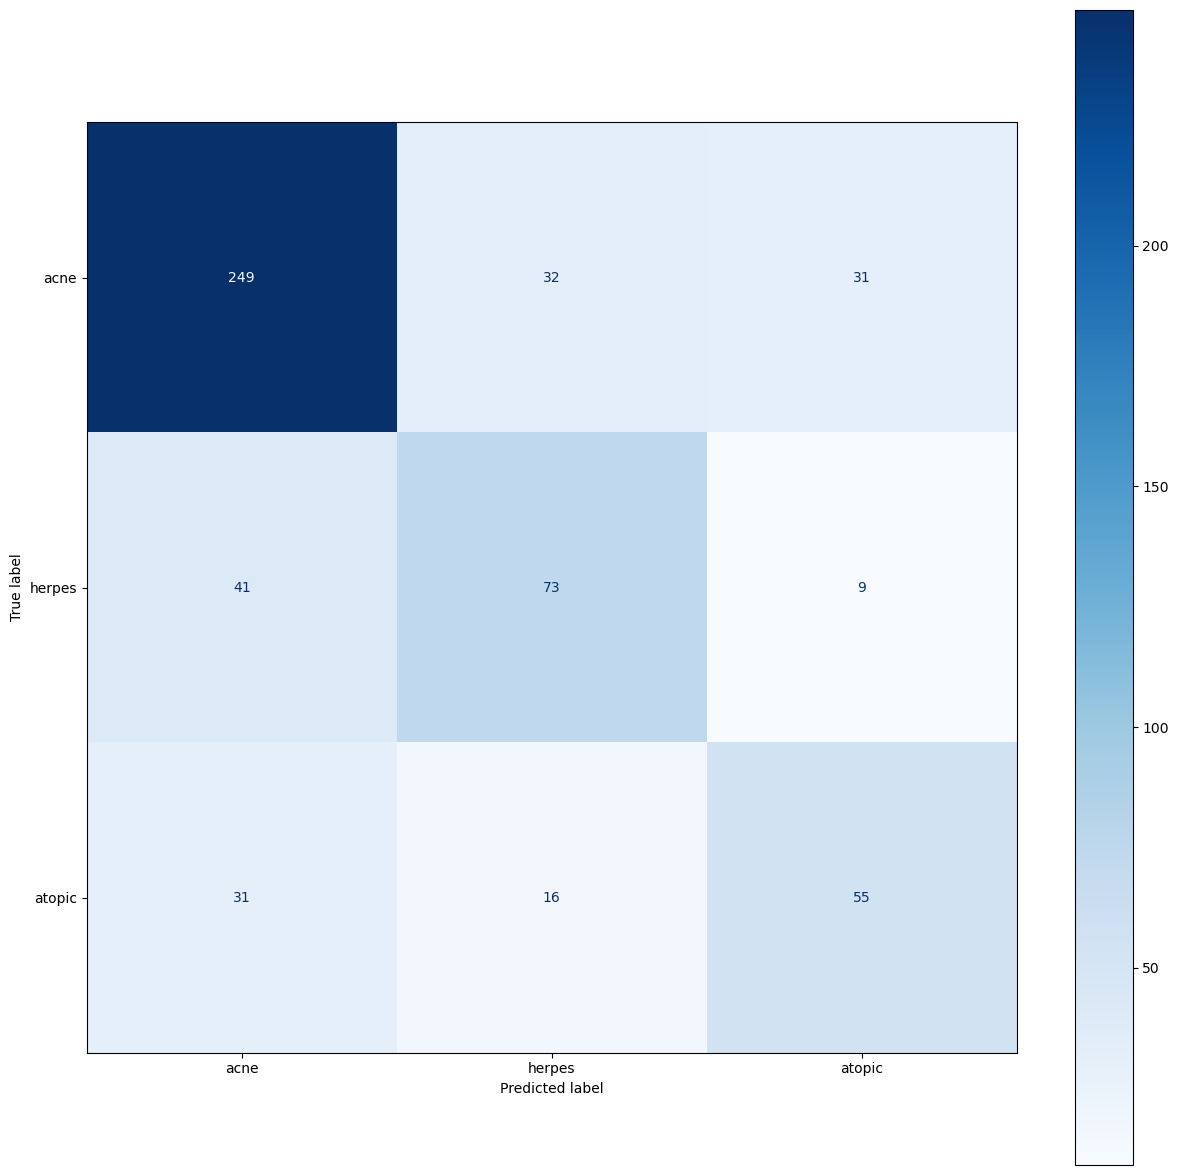

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acne', 'herpes', 'atopic'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [63]:
test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[acne_test_df, herpes_test_df, atopic_test_df])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

537/537 [==============================] - 7s 12ms/step


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x72fa06e0c200> (for post_execute):


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1500x1500 with 2 Axes>

In [64]:
result = model.evaluate(test_generator,batch_size=64)
print("test_loss, test accuracy",result)

537/537 [==============================] - 8s 15ms/step - loss: 0.7411 - categorical_accuracy: 0.7020
test_loss, test accuracy [0.7410930395126343, 0.7020484209060669]


In [65]:
resnet_preds = model.predict(test_generator)
resnet_pred_classes = np.argmax(resnet_preds, axis=1)

537/537 [==============================] - 6s 12ms/step


In [66]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())


resnet_acc = accuracy_score(true_classes, resnet_pred_classes)
print("Resnet50 Model Accuracy: {:.2f}%".format(resnet_acc * 100))

Resnet50 Model Accuracy: 70.20%


In [67]:
img = tf.keras.utils.load_img(
    '../input/dermnet/test/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-keratosis-5FU-32.jpg',
    target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


In [68]:
score = tf.nn.softmax(predictions[0])

class_names = list(train_generator.class_indices)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NameError: name 'predictions' is not defined

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
def predict_image_class(image_path,true_value):

    img = cv2.imread(image_path)
    img = cv2.resize(img,(256,256))

    img = np.expand_dims(img, axis=0)

    img_class = model.predict(img, batch_size=1)
    
    score = tf.nn.softmax(img_class[0])

    class_names = list(train_generator.class_indices)

    print(
        "This image most likely belongs to {}"
        .format(class_names[np.argmax(score)])
    )
    
    
    # for folder_name in our_folders:
    fig = plt.figure(1, figsize=(15, 15))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.05)
    ax = grid[0]
    img = load_img(image_path, (256, 256), color_mode="rgb")
    img = img_to_array(img)
    ax.imshow(img / 255.)
    
    ax.text(10, 150, 'True Label: %s' % true_value.upper(), color='g', backgroundcolor='w',\
    alpha=0.8, size = 20)
    
    ax.text(10, 200, 'Predicted Label: %s' % class_names[np.argmax(score)].upper(), color='k', backgroundcolor='w',\
    alpha=0.8, size = 20)
    ax.axis('off')
    plt.show()

In [ ]:
predict_image_class('/kaggle/input/dermnet/test/Acne and Rosacea Photos/acne-closed-comedo-15.jpg','Acne')

In [ ]:
predict_image_class('/kaggle/input/dermnet/test/Herpes HPV and other STDs Photos/11herpesAnal0913041.jpg','Herpes')

In [ ]:
predict_image_class('/kaggle/input/dermnet/test/Atopic Dermatitis Photos/05Atopic12060414.jpg','Atopic')

In [ ]:
# Wrong predictions
predict_image_class('../input/dermnet/test/Acne and Rosacea Photos/Forest-2.jpg','unknown')